<a href="https://colab.research.google.com/github/Avipsa1/UPPP275-Notebooks/blob/main/Voronoi_polygons_for_crimes_in_New_York_city_using_folium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# install with "plotting" dependencies (recommended):
!pip install -U geovoronoi[plotting]
!pip install geopandas
!python -m pip uninstall matplotlib --y
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 11.2 MB 31.1 MB/s 
     |████████████████████████████████| 1.0 MB 52.5 MB/s 
     |████████████████████████████████| 16.7 MB 53.7 MB/s 
     |████████████████████████████████| 6.3 MB 9.3 MB/s 
     |████████████████████████████████| 930 kB 44.0 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: matplotlib 3.5.2
Uninstalling matplotlib-3.5.2:
  Successfully uninstalled matplotlib-3.5.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 17.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Let us import the libraries and read the data first.

In [105]:
import geopandas as gpd
import numpy as np
import geovoronoi
import shapely
import pandas as pd
from geovoronoi import voronoi_regions_from_coords
import matplotlib.pyplot as plt
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from shapely.ops import cascaded_union
from geovoronoi import voronoi_regions_from_coords, points_to_coords
import folium
import random

Read the crimes dataset for New York city from the file "NYC_crime.csv"

In [34]:
crimes = pd.read_csv("NYC_crime.csv")
crimes.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,JURIS_DESC,...,PARKS_NM,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,749595529,34,MANHATTAN,1/1/16,0:01:00,1/1/18,0:01:00,COMPLETED,NaN,N.Y. POLICE DEPT,...,NaN,175,"SEXUAL ABUSE 3,2",RESIDENCE - APT. HOUSE,9/6/21,1002106,249501,40.851488,-73.935458,"(40.85148777400008, -73.93545796699993)"
1,134301299,25,MANHATTAN,1/1/16,8:00:00,12/31/17,9:00:00,COMPLETED,NaN,N.Y. HOUSING POLICE,...,NaN,175,"SEXUAL ABUSE 3,2",RESIDENCE - PUBLIC HOUSING,8/11/21,1000555,230994,40.800694,-73.941109,"(40.800694331000045, -73.94110928599997)"
2,813010521,13,MANHATTAN,1/1/16,0:01:00,5/1/19,23:59:00,COMPLETED,NaN,N.Y. POLICE DEPT,...,NaN,175,"SEXUAL ABUSE 3,2",PUBLIC SCHOOL,6/27/21,988874,207673,40.736698,-73.983316,"(40.736698070000045, -73.98331602599995)"
3,314597003,30,MANHATTAN,1/1/16,0:00:00,6/14/21,19:22:00,COMPLETED,NaN,N.Y. POLICE DEPT,...,NaN,180,COURSE OF SEXUAL CONDUCT AGAIN,RESIDENCE - APT. HOUSE,6/14/21,999794,241252,40.828851,-73.943834,"(40.82885104500008, -73.94383419099995)"
4,253714310,20,MANHATTAN,1/1/16,0:01:00,12/31/19,23:59:00,COMPLETED,NaN,N.Y. POLICE DEPT,...,NaN,420,"LARCENY,GRAND BY OPEN/COMPROMISE CELL PHONE ACCT",RESIDENCE - APT. HOUSE,3/30/21,990909,224857,40.783862,-73.975956,"(40.78386245300004, -73.97595583399993)"


Construct a GeoDataFrame from the CSV file.

In [35]:
#Convert the crimes data into a geodataframe
crimes_gdf = gpd.GeoDataFrame(
    crimes, geometry=gpd.points_from_xy(crimes.Longitude, crimes.Latitude))

crimes_gdf.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,JURIS_DESC,...,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,geometry
0,749595529,34,MANHATTAN,1/1/16,0:01:00,1/1/18,0:01:00,COMPLETED,NaN,N.Y. POLICE DEPT,...,175,"SEXUAL ABUSE 3,2",RESIDENCE - APT. HOUSE,9/6/21,1002106,249501,40.851488,-73.935458,"(40.85148777400008, -73.93545796699993)",POINT (-73.93546 40.85149)
1,134301299,25,MANHATTAN,1/1/16,8:00:00,12/31/17,9:00:00,COMPLETED,NaN,N.Y. HOUSING POLICE,...,175,"SEXUAL ABUSE 3,2",RESIDENCE - PUBLIC HOUSING,8/11/21,1000555,230994,40.800694,-73.941109,"(40.800694331000045, -73.94110928599997)",POINT (-73.94111 40.80069)
2,813010521,13,MANHATTAN,1/1/16,0:01:00,5/1/19,23:59:00,COMPLETED,NaN,N.Y. POLICE DEPT,...,175,"SEXUAL ABUSE 3,2",PUBLIC SCHOOL,6/27/21,988874,207673,40.736698,-73.983316,"(40.736698070000045, -73.98331602599995)",POINT (-73.98332 40.73670)
3,314597003,30,MANHATTAN,1/1/16,0:00:00,6/14/21,19:22:00,COMPLETED,NaN,N.Y. POLICE DEPT,...,180,COURSE OF SEXUAL CONDUCT AGAIN,RESIDENCE - APT. HOUSE,6/14/21,999794,241252,40.828851,-73.943834,"(40.82885104500008, -73.94383419099995)",POINT (-73.94383 40.82885)
4,253714310,20,MANHATTAN,1/1/16,0:01:00,12/31/19,23:59:00,COMPLETED,NaN,N.Y. POLICE DEPT,...,420,"LARCENY,GRAND BY OPEN/COMPROMISE CELL PHONE ACCT",RESIDENCE - APT. HOUSE,3/30/21,990909,224857,40.783862,-73.975956,"(40.78386245300004, -73.97595583399993)",POINT (-73.97596 40.78386)


Set a coordinate reference system for the GeoDataFrame

In [36]:
#Set a projection
crimes_gdf = crimes_gdf.set_crs(4326)

Import the NYC borough polygons from the file 'NYC Borough Boundaries.geojson'

In [92]:
boundary = gpd.read_file("NYC Borough Boundaries.geojson")

Overlay the points NYC crime locations on top of borough boundaries to see where they occur.

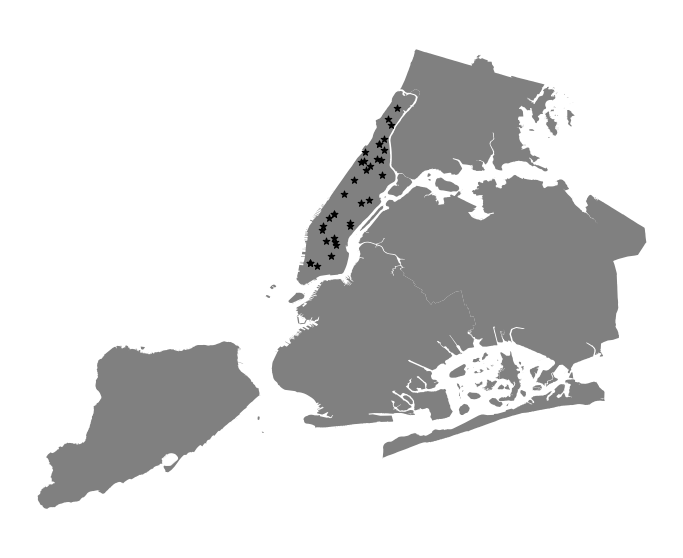

In [37]:
#Plot the crime locations on top of the NYC boroughs

fig, ax = plt.subplots(figsize=(12, 10))
boundary.plot(ax=ax, color="grey")
crimes_gdf.plot(ax=ax, markersize=50, color="black", marker = "*")
ax.axis("off")
plt.axis('equal')
plt.show()

Now, make sure you match the coordinate reference systems of both crimes and boroughs.

In [99]:
#Convert projections
boundary = boundary.to_crs(epsg=4326)
crimes_gdf = crimes_gdf.to_crs(boundary.crs)

Filter the borough GeoDataFrame to select only 'Manhattan' as that is where most crimes have occurred.

In [100]:
boundary.head()

,boro_code,boro_name,shape_area,shape_leng,geometry
0,4,Queens,3040205594.95,900269.280485,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."
1,3,Brooklyn,1934167333.21,728477.954082,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."
2,5,Staten Island,1623631283.36,325924.002076,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
3,1,Manhattan,636620785.519,359993.126318,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
4,2,Bronx,1187193588.79,463868.599917,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."


In [101]:
#Create a single polygon for Manhattan
boundary_shape = boundary.geometry[3]

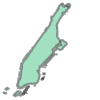

In [102]:
boundary_shape

Now exttract the point coordinates and generate the Voronoi regions from the selected borough polygon.

In [103]:
#Convert the geometry to points
coords = points_to_coords(crimes_gdf.geometry)

#Create the Voronoi regions for crime locations
region_polys, region_pts = voronoi_regions_from_coords(coords, boundary_shape)

Now, plot the Voronoi polygons along with the crime locations

/usr/local/lib/python3.7/dist-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/usr/local/lib/python3.7/dist-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


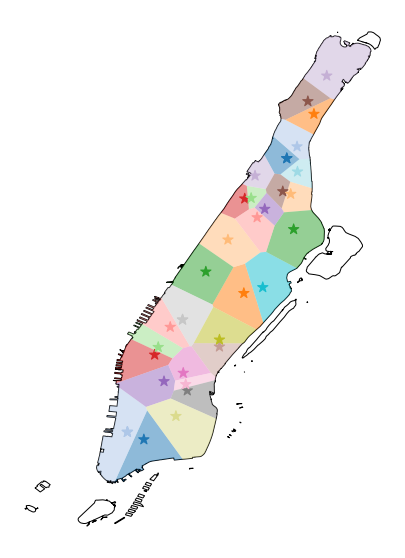

In [104]:
#Plot the Voronoi polygons with the crime-locations
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area

fig, ax = subplot_for_map(figsize = (10,10))
plot_voronoi_polys_with_points_in_area(ax, boundary_shape, region_polys, coords, region_pts, points_markersize= 120, points_marker= "*")
plt.show()

Now, let us try to make an interactive plot with folium. First we will add a basemap and center it around New York city.

In [106]:
#create a basemap
m = folium.Map(location=[40.89, -73.89], zoom_start=10, tiles='CartoDB positron')
m

In order to mark each Voronoi polygon with a unique color we will write a small function to create a Hexcode for colormap.

In [107]:
#Generate colors of polygons randomly
def rand_colors(x):
  r = "#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])
  return(r)

Next, let us add the Voronoi region polygons to this basemap using a for loop and then the folium.GeoJson() function.

In [108]:
#Add Voronoi polygons from the region_polys using for-loop

for count, r in enumerate(region_polys.values()):
  #Pick the row index of the GeoDataFrame
  dfindex = region_pts[count][0]
  #Select all columns from the chosen row
  d = crimes_gdf.loc[dfindex]
  #Select those columns we want to display in the pop-up
  premise = d['PREM_TYP_DESC']
  crimeType = d['PD_DESC']
  date = d['CMPLNT_FR_DT']
  desc = d['LAW_CAT_CD']
  #Create a display symbol for the popup for each polygon
  popup = f'{premise} \nOccurred: {date}\nType: {crimeType}'
  #Draw the polygon on the map
  geo_j = folium.GeoJson(data=r,  style_function=lambda x: {'fillColor': rand_colors(x), 'color' : 'silver'}, tooltip = desc)
  folium.Popup(popup).add_to(geo_j)
  geo_j.add_to(m)

Now, display the Voronoi polygons on the basemap

In [109]:
m

Next, we will add a marker cluster map that we generate using folium.Marker() function to show the actual location of the crimes.

In [110]:
#Now add the points on top

from folium import plugins
marker_cluster = folium.plugins.MarkerCluster().add_to(m)

#Loop over the x and y coordinates from the geometry column in the 'gdf' geodataframe
for row in crimes_gdf.itertuples():
    folium.Marker(location=[row.geometry.y,row.geometry.x],popup=row.PD_DESC).add_to(marker_cluster)


m